# Read Noise Distributions

<br>Owner: **Emily Phillips Longley** and **Keith Bechtol**
<br>Last Verified to Run: **2018-11-14**
<br>Verified Stack Release: **w_2018_45**

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions in `welcome_to_FE55.ipynb`.

See examples in the eotest:
* [read_noise.py](https://github.com/lsst-camera-dh/eotest/blob/master/python/lsst/eotest/sensor/read_noise.py)
* [total_noise_histograms.py](https://github.com/lsst-camera-dh/eotest/blob/master/python/lsst/eotest/sensor/total_noise_histograms.py)

Our goal is to compute determine the noise distributions for each amplifier. The total noise has contributions from read noise, system noise, and shot noise added in quadrature.

$\sigma_{\rm total} = \sqrt{\sigma_{\rm read}^{2} + \sigma_{\rm system}^{2} + \sigma_{\rm shot}^{2}}$

**Read noise:**

**System noise:**

**Total read noise:**

To get the gain, use flats. This is an approximation.

$\left< \frac{(I_1 - I_2)^2}{I_1 + I_2} \right> = \frac{2 \mu g^{-2}}{2 \mu g^{-1}} = \frac{1}{g}$

For Poisson distribution

$\sigma^2 = \mu$

Use bias frames

$(I_1 - I_2)^2 = \frac{2 \sigma^2}{g^2}$

**Shot noise:** Poisson noise contribution from dark current. The variance is equal to the dark current (electrons per second) multiplied by the exposure time (seconds).

Other things to check. Look at adjascent pixels. Correlations. Some will be correlated, some will be uncorrelated.

Inputs include the 
* gain per amp, 
* dark current array over pixels

In [1]:
! eups list -s | grep lsst_distrib

lsst_distrib          16.0-1-g3bbe181+33 	current d_2018_11_14 setup


In [2]:
%matplotlib inline
#%matplotlib notebook

# system imports
import os
import pickle
import numpy as np
from matplotlib import pylab as plt

# LSST stack imports
from lsst.daf.persistence import Butler
from lsst.ip.isr import IsrTask
import lsst.afw.display as afwDisplay
import lsst.afw.math as afwMath

# Firefly client imports
from firefly_client import FireflyClient
from IPython.display import IFrame

We will neeed the gains as input.

In [3]:
reader = open('../examples/gain_detector_2.pkl', 'rb')
gain_dict = pickle.load(reader)
reader.close()

# Unit is electrons per ADU
print(gain_dict)

{'C10': 0.6856116841023682, 'C11': 0.6828370373440649, 'C12': 0.6805327849191469, 'C13': 0.6831846044769826, 'C14': 0.6849149825346197, 'C15': 0.6789655903769061, 'C16': 0.6829431546099424, 'C17': 0.6876745548876412, 'C07': 0.6810742462801476, 'C06': 0.6756125428248168, 'C05': 0.6789986278561932, 'C04': 0.6769254142894018, 'C03': 0.6782587666477135, 'C02': 0.6773377949311571, 'C01': 0.6754054168143772, 'C00': 0.6720678721650647}


Run the ISR task through correction with the master bias.

In [4]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False

isr_bias = IsrTask(config=isr_config)

#isr_config.toDict()

Alternative ISR configuration to run the ISR task through CCD assembly. This includes overscan subtraction.

In [5]:
isr_config = IsrTask.ConfigClass()

isr_config.doBias=False
isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False

isr_assemble = IsrTask(config=isr_config)

In [6]:
# Instantiate butler and print out what types of raw exposures exist in this data repository
BOOTCAMP_REPO_DIR = '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
butler.queryMetadata('raw', ['imageType'])

['BIAS', 'DARK', 'FE55', 'FLAT', 'fluxcalib', 'PPUMP']

## Read noise

In [39]:
# Start by identifying one bias frame
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'BIAS'})
print(visits)

[258334360, 258334672, 258334985, 258335297, 258335608, 258338033, 258338346, 258338660, 258338973, 258339284, 258339732, 258339799, 258339867, 258339937, 258340007, 258340077, 258340152, 258340195, 258340236, 258340282, 258340332, 258340383, 258340438, 258340500, 258340568, 258340646, 258340740, 258340850, 258340989, 258341162, 258341382, 258341635, 258341916, 258342229, 258342550, 258342881, 258343221, 258343573, 258343932, 258344308, 258344701, 258345114, 258345543, 258345990, 258346455, 258346938, 258347437, 258347953, 258348488, 258350158, 258350371, 258350670, 258350693, 258350717, 258350742, 258350767, 258350790, 258350815, 258350838, 258350863, 258350887, 258350911, 258350935, 258350959, 258350984, 258351008, 258351032, 258351057, 258351081, 258351105, 258351130, 258351154, 258351178, 258351202, 258351226, 258351250, 258351292, 258351436, 258351575, 258351712, 258351849, 258351986, 258352118, 258352254, 258352394, 258352528, 258353336, 258353632, 258353884, 258354053, 258354195

In [40]:
dId = dict(visit=visits[0], detector=2) # Note that detector is a required keyword
print(dId)

{'visit': 258334360, 'detector': 2}


In [11]:
raw = butler.get('raw', dId)
raw_assemble = raw.clone() # We are worried that there is modify in place
raw_bias = raw.clone()

# Show metadata for this frame
#print(raw.getMetadata())

# Show the detector name
#raw.getDetector().getName()

In [12]:
# Get the corresponding master bias and master dark
bias = butler.get('bias', dId)
dark = butler.get('dark', dId)

In [11]:
result_assemble = isr_assemble.run(raw_assemble)
result_bias = isr_bias.run(raw_bias, bias=bias)

7.5743413
7.0380545
(4004, 4096)
(4004, 4096)


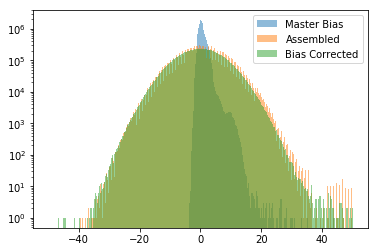

In [15]:
raw_image = raw.getMaskedImage().getImage().getArray()
assemble_corrected_image = result_assemble.exposure.getMaskedImage().getImage().getArray()
bias_corrected_image = result_bias.exposure.getMaskedImage().getImage().getArray()
master_bias_image = bias.getMaskedImage().getImage().getArray()

print(np.std(assemble_corrected_image))
print(np.std(bias_corrected_image))
print(assemble_corrected_image.shape)
print(bias_corrected_image.shape)

bins = np.linspace(-50, 50, 401)
plt.figure()
plt.yscale('log')
plt.hist(master_bias_image.flatten(), bins=bins, alpha=0.5, label='Master Bias')
plt.hist(assemble_corrected_image.flatten(), bins=bins, alpha=0.5, label='Assembled')
plt.hist(bias_corrected_image.flatten(), bins=bins, alpha=0.5, label='Bias Corrected')
plt.legend(loc='upper right')

# Noise Stability



In [ ]:
std_of_biases = []  
for visit in visits:
    dId = dict(visit=visit, detector=2) # Note that detector is a required keyword
    raw = butler.get('raw', dId)
    raw_corrected = raw.clone()
    one_bias = isr_bias.run(raw_corrected, bias=bias)
    std_of_biases.append(np.std(one_bias.exposure.getImage().getArray()))

Text(0.5,0,'Bias Frame Number')

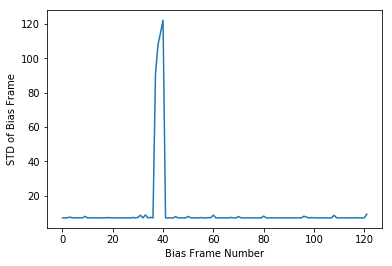

In [28]:
plt.plot(std_of_biases)
plt.ylabel('STD of Bias Frame')
plt.xlabel('Bias Frame Number')

In [13]:
# Seems like there are three weird bias frames let's take a look 
#std_of_biases[37:40]
dId = dict(visit=visits[37], detector=2)
raw = butler.get('raw', dId)
raw_corrected = raw.clone()
weird_bias = isr_bias.run(raw_corrected, bias=bias)

90.87173946315336


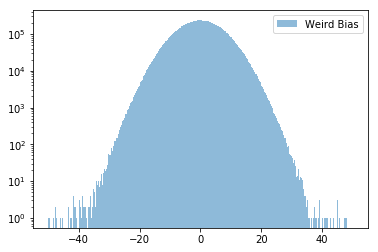

In [52]:
weird_bias_image = weird_bias.exposure.getImage().getArray()

print(afwMath.makeStatistics(weird_bias.exposure.getMaskedImage(), afwMath.STDEV).getValue())

bins = np.linspace(-50, 50, 401)
plt.figure()
plt.yscale('log')
plt.hist(weird_bias_image.flatten(), bins=bins, alpha=0.5, label='Weird Bias')
plt.legend(loc='upper right')

7.0380545


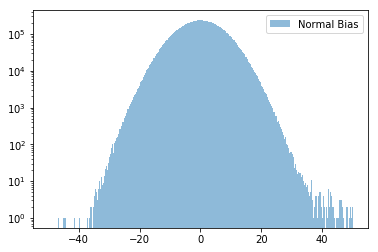

In [15]:
# Seems like there are three weird bias frames let's take a look 
dId = dict(visit=visits[0], detector=2)
raw = butler.get('raw', dId)
raw_corrected = raw.clone()
normal_bias = isr_bias.run(raw_corrected, bias=bias)

normal_bias_image = normal_bias.exposure.getImage().getArray()

print(np.std(normal_bias_image))

bins = np.linspace(-50, 50, 401)
plt.figure()
plt.yscale('log')
plt.hist(normal_bias_image.flatten(), bins=bins, alpha=0.5, label='Normal Bias')
plt.legend(loc='upper right')

In [21]:
#Looks like some of the overscan subtraction isn't working for all of the bias frames

print(np.min(normal_bias_image))
print(np.max(normal_bias_image))

print(np.min(weird_bias_image))
print(np.max(weird_bias_image))

-94.97266
103.77698
-75.463196
24528.604


In [66]:
weirdpix_xs = []
weirdpix_ys = []
for x in range(weird_bias_image.shape[0]):
    for y in range(weird_bias_image.shape[1]):
        if weird_bias_image[x][y] > 20000:
            weirdpix_xs.append(x)
            weirdpix_ys.append(y)

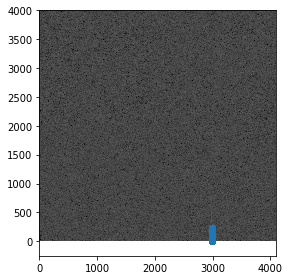

In [76]:
#afw_display = afwDisplay.getDisplay(frame=1, 
#                                    name=my_channel)
#afw_display.mtv(result.exposure)

afwDisplay.setDefaultBackend('matplotlib')
my_display = afwDisplay.Display()
my_display.scale("asinh", "zscale")
#my_display.mtv(raw.getMaskedImage()) # Plot the raw image
my_display.mtv(weird_bias.exposure) # Plot the CCD assembled, overscan subtracted image
plt.scatter(weirdpix_ys, weirdpix_xs)
#my_display.mtv(result_bias.exposure) # Plot the master bias corrected image
#my_display.mtv(bias.getMaskedImage()) # Plot the master bias

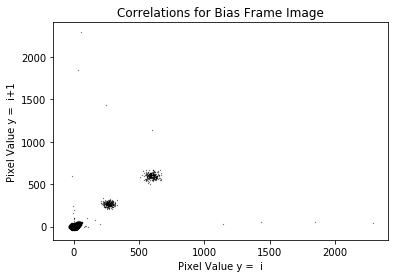

In [15]:
#The bias frames often have structure in both the parallel and serial direction.  Overscan correction does not get rid of it, 
#which is why images need to be both overscan and bias corrected.  It's stronger in ITL devices, but e2v has some structure 
#as well.

# Older configuration from march or april due to how the reset is applied 

# Look if it's stable and compare to ITL 

#It is interesting to note that this causes correlations in the bias frame that are then subtracted out in the corrected image.

x = assemble_corrected_image.flatten("F")[0:-2]
y = assemble_corrected_image.flatten("F")[1:-1]
plt.scatter(x,y,marker='.',color='black',s=0.2)
plt.title('Correlations for Bias Frame Image')
plt.xlabel('Pixel Value y =  i')
plt.ylabel('Pixel Value y =  i+1')
plt.show()

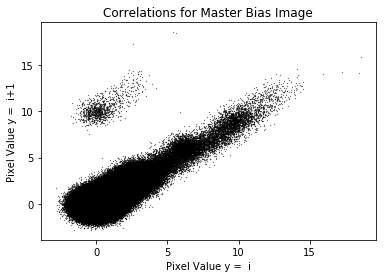

In [18]:
#The bias frames often have structure in both the parallel and serial direction.  Overscan correction does not get rid of it, 
#which is why images need to be both overscan and bias corrected.  It's stronger in ITL devices, but e2v has some structure 
#as well.

# Older configuration from march or april due to how the reset is applied 

# Look if it's stable and compare to ITL 

#It is interesting to note that this causes correlations in the bias frame that are then subtracted out in the corrected image.

lim = 1000
x = master_bias_image[0:lim,0:lim].flatten("F")[0:-2]
y = master_bias_image[0:lim,0:lim].flatten("F")[1:-1]
plt.scatter(x,y,marker='.',color='black',s=0.2)
plt.title('Correlations for Master Bias Image')
plt.xlabel('Pixel Value y =  i')
plt.ylabel('Pixel Value y =  i+1')
plt.show()

Text(0,0.5,'Pixel Value y =  i+1')

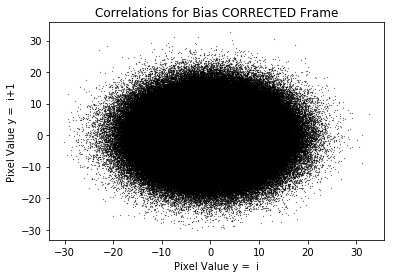

In [19]:
#The bias frames often have structure in both the parallel and serial direction.  Overscan correction does not get rid of it, 
#which is why images need to be both overscan and bias corrected.  It's stronger in ITL devices, but e2v has some structure 
#as well.  

#It is interesting to note that this causes correlations in the bias frame that are then subtracted out in the corrected image.

lim = 1000
x = bias_corrected_image[0:lim,0:lim].flatten("F")[0:-2]
y = bias_corrected_image[0:lim,0:lim].flatten("F")[1:-1]
plt.scatter(x,y,marker='.',color='black',s=0.2)
plt.title('Correlations for Bias CORRECTED Frame')
plt.xlabel('Pixel Value y =  i')
plt.ylabel('Pixel Value y =  i+1')


In [68]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'

ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600)

In [69]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

In [77]:
afw_display.mtv(weird_bias.exposure)
#afw_display.mtv(bias.getMaskedImage())

In [23]:
#Calculate from the overscan region 

detector = raw.getDetector()
noise_from_vertical_overscan = np.empty(len(detector))
noise_from_horizontal_overscan = np.empty(len(detector))
overscans_horiz = []
overscans_vert = []
for ii, amp in enumerate(detector):
    bbox = detector[amp.getName()].getRawVerticalOverscanBBox()
    bbox_horiz = detector[amp.getName()].getRawHorizontalOverscanBBox()
    overscans_vert.append(raw[bbox].getMaskedImage())
    overscans_horiz.append(raw[bbox_horiz].getMaskedImage())
    noise_from_vertical_overscan[ii] = afwMath.makeStatistics(overscans_vert[ii], afwMath.STDEV).getValue()*gain_dict[amp.getName()]
    noise_from_horizontal_overscan[ii] = afwMath.makeStatistics(overscans_horiz[ii], afwMath.STDEV).getValue()*gain_dict[amp.getName()]

In [24]:
print(noise_from_vertical_overscan)
print(noise_from_horizontal_overscan)

[ 4.61708076  4.7247853   4.69074106  4.69442262  4.6583689   4.841165
  4.81707878  4.96958389  4.93468414  4.76880895 19.45743975  4.69631911
  5.08866718  5.04385004  5.01822629  5.19926545]
[4.55484913 4.64647847 4.643499   4.63994421 4.63352176 4.79296781
 4.77957706 4.92198202 4.92827048 4.76703011 4.70129602 4.70327642
 5.04941321 4.97630802 4.99894451 5.15322622]


In [25]:
overscan_vert_array = overscans_vert[15].getArrays()[0]
overscan_horiz_array = np.flip(overscans_horiz[15].getArrays()[0],axis=0)

print(overscan_vert_array.shape)
print(np.flip(overscan_horiz_array.shape,axis=0))

(46, 512)
[  54 2002]


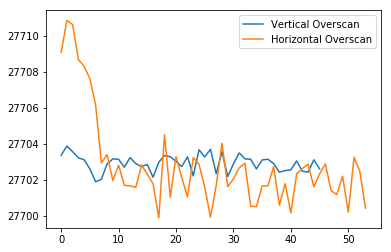

In [26]:
#Look at the different overscan regions 

plt.plot(range(46),[np.mean(overscan_vert_array[i]) for i in range(46)],label='Vertical Overscan' )
plt.plot(range(54),[np.mean(overscan_horiz_array[i]) for i in range(54)],label='Horizontal Overscan')
plt.legend(loc='best')

In [27]:
print(detector[amp.getName()].getRawVerticalOverscanBBox())
print(detector[amp.getName()].getRawHorizontalOverscanBBox())

(minimum=(10, 2048), maximum=(521, 2093))
(minimum=(522, 2094), maximum=(575, 4095))


In [28]:
# Let's do the calculation
detector = result_bias.exposure.getDetector()
noise_from_master_bias = np.empty(len(detector))
print('%5s%15s'%('Amp', 'Noise (e)'))
for ii, amp in enumerate(detector):
    amp_image = result_bias.exposure.getMaskedImage()[amp.getBBox()]
    overscan = amp.getRawHorizontalOverscanBBox()
    stats = afwMath.makeStatistics(amp_image, afwMath.STDEV)
    noise_from_master_bias[ii] = gain_dict[amp.getName()] * stats.getValue(afwMath.STDEV)
    print('%5s%15.2f'%(amp.getName(), 
                       noise_from_master_bias[ii]))

  Amp      Noise (e)
  C10           4.55
  C11           4.61
  C12           4.61
  C13           4.61
  C14           4.61
  C15           4.77
  C16           4.74
  C17           4.91
  C07           4.90
  C06           4.73
  C05           4.73
  C04           4.70
  C03           5.02
  C02           4.96
  C01           4.96
  C00           5.11


Let's compute the read noise in a different way.

In [29]:
dId_1 = dict(visit=visits[0], detector=2)
dId_2 = dict(visit=visits[1], detector=2)

raw_1 = butler.get('raw', dId_1)
raw_2 = butler.get('raw', dId_2)

result_assemble_1 = isr_assemble.run(raw_1)
result_assemble_2 = isr_assemble.run(raw_2)

In [30]:
noise_from_difference = np.empty(len(detector))
for ii, amp in enumerate(detector):
    sub_im1 = result_assemble_1.exposure.getMaskedImage()[amp.getBBox()]
    sub_im2 = result_assemble_2.exposure.getMaskedImage()[amp.getBBox()]
    
    # From RHL, 1/g = <(I1-I2)**2/(I1+I2)>
    diff_im = sub_im1.clone()
    diff_im -= sub_im2
    
    stats = afwMath.makeStatistics(diff_im, afwMath.STDEV)
    
    noise_from_difference[ii] = gain_dict[amp.getName()] * (np.sqrt(2))**(-1) * stats.getValue(afwMath.STDEV)
    
    print('%5s%15.2f'%(amp.getName(), 
                       noise_from_difference[ii]))

  C10           4.57
  C11           4.63
  C12           4.62
  C13           4.64
  C14           4.63
  C15           4.78
  C16           4.76
  C17           4.94
  C07           4.92
  C06           4.75
  C05           4.74
  C04           4.71
  C03           5.04
  C02           4.98
  C01           4.98
  C00           5.13


In [31]:
#a = np.random.uniform(size=10000)
#print(np.std(a * 100))
#print(100 * np.std(a))

Text(0,0.5,'Noise (e)')

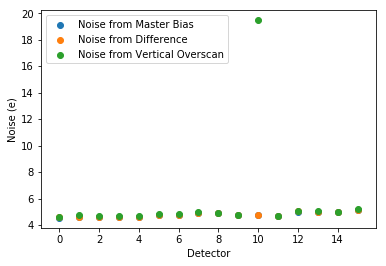

In [32]:
# Plot the SRD Requirements - note u-band 

plt.figure()
x = np.arange(16)
plt.scatter(x, noise_from_master_bias, label='Noise from Master Bias')
plt.scatter(x, noise_from_difference, label='Noise from Difference')
plt.scatter(x, noise_from_vertical_overscan, label='Noise from Vertical Overscan')
#plt.scatter(x, noise_from_difference / noise_from_master_bias, label='Noise from Difference')
plt.legend()
plt.xlabel('Detector')
plt.ylabel('Noise (e)')

Text(0,0.5,'Noise (e)')

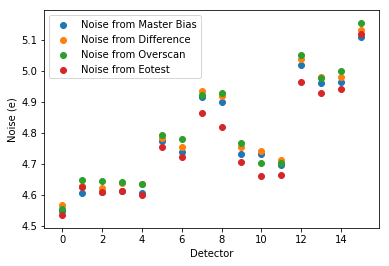

In [36]:
# Plot the SRD Requirements - note u-band

#LSC 30 OSS ReQ 0267 
# LSC 59 CAM REQ 0020 
eotest_results = [4.534455299377441, 4.623283863067627, 4.608121871948242, 4.612620830535889, 4.598947048187256, 4.754878520965576, 4.720862865447998, 4.863598346710205, 4.819451332092285, 4.705887317657471, 4.661146640777588, 4.661833763122559, 4.96422815322876, 4.929252624511719, 4.940608024597168, 5.118816375732422]

plt.figure()
x = np.arange(16)
plt.scatter(x, noise_from_master_bias, label='Noise from Master Bias')
plt.scatter(x, noise_from_difference, label='Noise from Difference')
plt.scatter(x, noise_from_horizontal_overscan, label='Noise from Overscan')
plt.scatter(x, eotest_results, label='Noise from Eotest')
#plt.scatter(x, noise_from_difference / noise_from_master_bias, label='Noise from Difference')
plt.legend()
plt.xlabel('Detector')
plt.ylabel('Noise (e)')

Text(0,0.5,'Ratio')

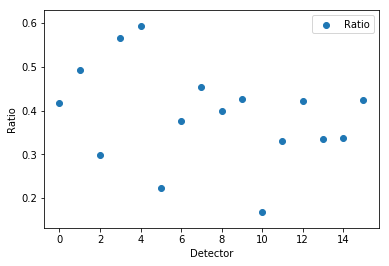

In [34]:
plt.figure()
x = np.arange(16)
#plt.scatter(x, noise_from_master_bias, label='Noise from Master Bias')
#plt.scatter(x, noise_from_difference, label='Noise from Difference')
#plt.scatter(x, noise_from_horizontal_overscan, label='Noise from Overscan')
plt.scatter(x, 100*(noise_from_difference / noise_from_master_bias-1), label='Ratio')
plt.legend()
plt.xlabel('Detector')
plt.ylabel('Ratio')

## Dark Noise

The master dark image has units of ADU per second. To compute the median number of electrons per pixel for each amp, multiply by the median of the master dark image by the gain for that amp as well as the exposure time. We can interpret the median number of electron counts as the variance of a Poisson distribution. The noise is the square root of the variance.

Note that the EOTEST suite reports a 95% percentile for the dark current noise. We interet this as saying "5% of pixels have shot noise larger than this".

In [42]:
EXPTIME = 16 # seconds

In [37]:
dark.getMaskedImage().getImage().getArray()

# Find out what calibration frames went into creating the dark
print(dark.getMetadata())

OBSTYPE = "dark"
CALIB_CREATION_DATE = "2018-11-05"
CALIB_CREATION_TIME = "08:20:17 CST"
CALIB_INPUT_0 = "(258338339,)"
CALIB_INPUT_1 = "(258338653,)"
CALIB_INPUT_2 = "(258338967,)"
CALIB_INPUT_3 = "(258339279,)"
CALIB_INPUT_4 = "(258339589,)"
CALIB_ID = "detector=2 detectorName=S02 filter=NONE calibDate=2018-03-10"
MD5_IMAGE = "7c9d7be0b0bac1e635c2ec43ce35f1be"
MD5_MASK = "b3471c2dc5290d80ba8b2171d87bc084"
MD5_VARIANCE = "c6d3244b1f464b706eaa8fb5750b6d7a"
TTYPE1 = "COMPRESSED_DATA"
// label for field   1
TFORM1 = "1PB(14430)"
// data format of field: variable length array
ZQUANTIZ = "NONE"
// Lossless compression without quantization



In [43]:
detector = raw.getDetector()
noise_from_dark = np.empty(len(detector))
for ii, amp in enumerate(detector):
    im = dark.getMaskedImage()[amp.getBBox()]
    stats = afwMath.makeStatistics(im, afwMath.MEDIAN)
    
    noise_from_dark[ii] = np.sqrt(gain_dict[amp.getName()] * EXPTIME * stats.getValue(afwMath.MEDIAN))
    
    print('%5s%15.2f'%(amp.getName(), 
                       noise_from_dark[ii]))

  C10           0.41
  C11           0.42
  C12           0.44
  C13           0.44
  C14           0.44
  C15           0.47
  C16           0.48
  C17           0.52
  C07           0.51
  C06           0.50
  C05           0.49
  C04           0.48
  C03           0.47
  C02           0.46
  C01           0.46
  C00           0.45


Text(0.5,0,'Amplifier')

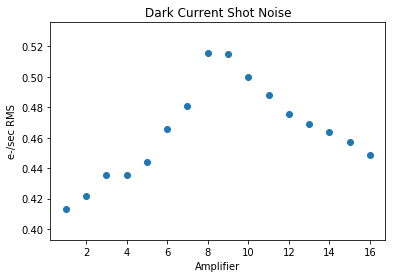

In [47]:
# Likel

plt.scatter(range(1,17),noise_from_dark)
plt.title('Dark Current Shot Noise')
plt.ylabel('e-/sec RMS')
plt.xlabel('Amplifier')

---

## Code Scraps

In [26]:
# Here's how to find out what visits went into making the master bias
#print(bias.getMetadata())

In [27]:
butler.queryMetadata('raw', ['detector', 'detectorName'])

[(0, 'S00'),
 (1, 'S01'),
 (2, 'S02'),
 (3, 'S10'),
 (4, 'S11'),
 (5, 'S12'),
 (6, 'S20'),
 (7, 'S21'),
 (8, 'S22')]

In [28]:
dark = butler.get('dark', dId)
dark.getMetadata().toDict()

for a in raw.getDetector():
    print(a.getName(), a.getReadNoise(), a.getGain())

C10 7.0 1.7
C11 7.0 1.7
C12 7.0 1.7
C13 7.0 1.7
C14 7.0 1.7
C15 7.0 1.7
C16 7.0 1.7
C17 7.0 1.7
C07 7.0 1.7
C06 7.0 1.7
C05 7.0 1.7
C04 7.0 1.7
C03 7.0 1.7
C02 7.0 1.7
C01 7.0 1.7
C00 7.0 1.7
